<H2> Metal Surface Defect Detection</H2>
This dataset is a portion of NEU Metal Surface Defects Database which contains six kinds of typical surface defects of the hot-rolled steel strip are collected. This dataset contains the images given below:

<b>Inclusion:</b> Inclusion is a typical defect of metal surface defects. Some inclusions are loose and easy to fall off, some pressed into the plate.

<b>Crazing:</b> Crazing is the phenomenon that produces some cracks on the surface of a material.

<b>Patches:</b> A part of metal marked out from the rest by a particular characteristic.

<b>Pitted surface:</b> Pitting is a form of corrosion that focuses on a very small range of metal surfaces and penetrates into the metal interior. Pitting is generally small in diameter but deep in depth.

<b>Scratches:</b> A scratch is a mark of abrasion on a surface.

<b>Rolled in scale:</b> A rolled-in scale defect occurs when the mill scale is rolled into the metal duringthe rolling process.
The dataset divided into 3 directories. The training directory contains 276 images of each class from the 300 images. The rest 24 images of each class also divided into tests and valid datasets.

<H2>Problam Statement</H2>

We have to create a machine learning or deep learning model which can detect the type of defect in the image of metal.

Importing necessary Liberaries

In [1]:
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
from tensorflow import keras
import itertools
from skimage import io, feature
from sklearn.model_selection import train_test_split
from sklearn import svm
import matplotlib.pyplot as plt
import pickle
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from tensorflow.keras.models import load_model
from skimage.measure import shannon_entropy
from PIL import Image
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Sequential
from mpl_toolkits.mplot3d import Axes3D
from sklearn.svm import SVC
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score, accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, Flatten, Dense, Dropout,BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard

Setting paths for train, validation and test dataset

In [2]:
train_dir = "C:\\Users\\shri\\Data_Science\\Guissipo Longo\\Assigned_Final_Project\\Metal_Surface_Defects\\NEU Metal Surface Defects Data\\train"
test_dir = "C:\\Users\\shri\\Data_Science\\Guissipo Longo\\Assigned_Final_Project\\Metal_Surface_Defects\\NEU Metal Surface Defects Data\\test"
valid_dir = "C:\\Users\\shri\\Data_Science\\Guissipo Longo\\Assigned_Final_Project\\Metal_Surface_Defects\\NEU Metal Surface Defects Data\\valid"

Statical Analysis of our Images

In [24]:
# Path to the folder containing images
image_folder = train_dir

# Initialize lists to store results
dimensions = []
aspect_ratios = []
pixel_intensities = []
entropies = []
edge_percentages = []

# Function to calculate edge percentage
def edge_percentage(image):
    edges = cv2.Canny(image, 100, 200)
    return np.sum(edges > 0) / edges.size

# Loop through images in the folder
for subfolder in os.listdir(image_folder):
    subfolder_path = os.path.join(image_folder, subfolder)
    if os.path.isdir(subfolder_path):
        for filename in os.listdir(subfolder_path):
            if filename.endswith((".bmp", ".jpg", ".png")):  # Supported formats
                file_path = os.path.join(subfolder_path, filename)

                # Read the image
                image = cv2.imread(file_path)
                if image is not None:
                    # Store dimensions
                    h, w, c = image.shape
                    dimensions.append((h, w, c))

                    # Calculate and store aspect ratio
                    aspect_ratios.append(w / h)

                    # Convert to grayscale
                    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

                    # Calculate and store mean pixel intensity
                    pixel_intensities.append(np.mean(gray_image))

                    # Calculate and store texture entropy
                    entropies.append(shannon_entropy(gray_image))

                    # Calculate and store edge percentage
                    edge_percentages.append(edge_percentage(gray_image))

# Convert to NumPy arrays for analysis
dimensions = np.array(dimensions)
aspect_ratios = np.array(aspect_ratios)
pixel_intensities = np.array(pixel_intensities)
entropies = np.array(entropies)
edge_percentages = np.array(edge_percentages)


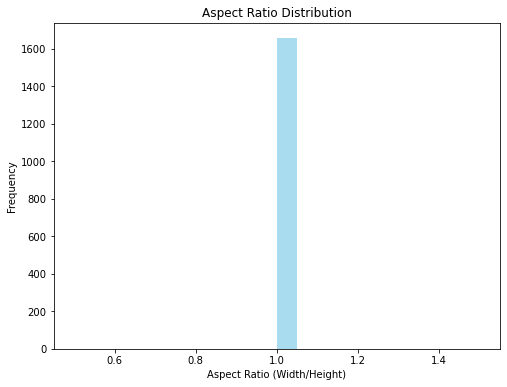

In [26]:
#  Aspect Ratios
plt.figure(figsize=(8, 6))
plt.hist(aspect_ratios, bins=20, color="skyblue", alpha=0.7)
plt.xlabel("Aspect Ratio (Width/Height)")
plt.ylabel("Frequency")
plt.title("Aspect Ratio Distribution")
plt.show()


Aspect Ratio
* The spike at 1.0 indicates that all or most of the images have an aspect ratio of 1, meaning they are square (width and height are equal)

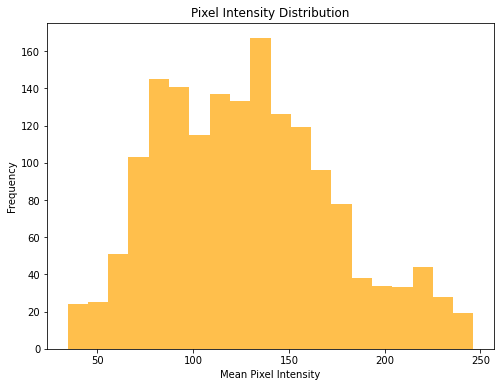

In [27]:
#  Pixel Intensity Distribution
plt.figure(figsize=(8, 6))
plt.hist(pixel_intensities, bins=20, color="orange", alpha=0.7)
plt.xlabel("Mean Pixel Intensity")
plt.ylabel("Frequency")
plt.title("Pixel Intensity Distribution")
plt.show()

Pixel Intensity Distribution:
* Most images have mean pixel intensities between 50 and 150, indicating that the dataset contains images that are predominantly of medium brightness.
* There are fewer very dark (low intensity) or very bright (high intensity) images.

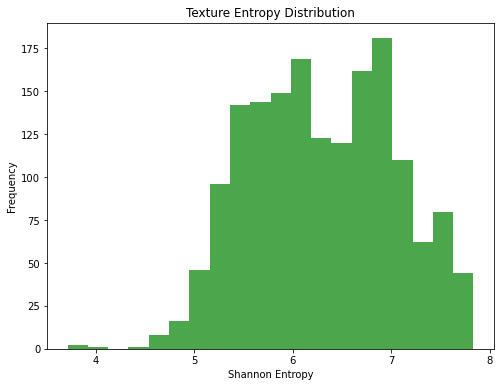

In [28]:
# Entropy (Texture Complexity)
plt.figure(figsize=(8, 6))
plt.hist(entropies, bins=20, color="green", alpha=0.7)
plt.xlabel("Shannon Entropy")
plt.ylabel("Frequency")
plt.title("Texture Entropy Distribution")
plt.show()

Dominant Entropy Range:

* Most images have entropy values between 5 and 7, suggesting the majority of your dataset contains moderately complex textures or patterns.
1. Few Low-Entropy Images:
* There are very few images with entropy values below 4, indicating that most images are not overly smooth or uniform.
2. High-Entropy Images:
* There are also some images with entropy above 7, which could indicate regions with fine details or noise.

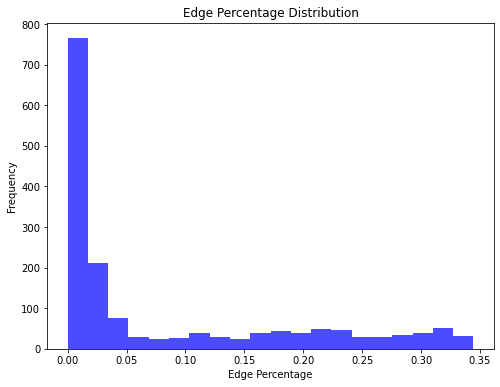

In [29]:
# Edge Percentage
plt.figure(figsize=(8, 6))
plt.hist(edge_percentages, bins=20, color="blue", alpha=0.7)
plt.xlabel("Edge Percentage")
plt.ylabel("Frequency")
plt.title("Edge Percentage Distribution")
plt.show()

Edge Percentage: The ratio of edge pixels (as detected by the Canny edge detection algorithm) to the total number of pixels in an image.
 * Higher edge percentages indicate images with more complex textures, fine details, or many transitions between regions (e.g., high contrast).
 * Lower edge percentages indicate smoother images with fewer details or larger homogeneous regions.

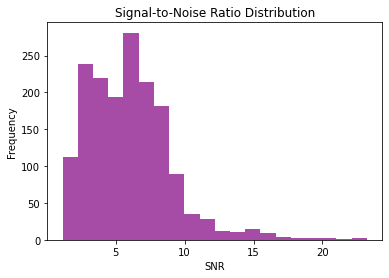

In [31]:
def calculate_snr(image):
    mean_signal = np.mean(image)
    noise = np.std(image)
    return mean_signal / noise

snr_values = []
for subfolder in os.listdir(image_folder):
    subfolder_path = os.path.join(image_folder, subfolder)
    if os.path.isdir(subfolder_path):
        for filename in os.listdir(subfolder_path):
            if filename.endswith((".bmp", ".jpg", ".png")):
                file_path = os.path.join(subfolder_path, filename)
                image = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
                if image is not None:
                    snr_values.append(calculate_snr(image))

plt.hist(snr_values, bins=20, color='purple', alpha=0.7)
plt.title("Signal-to-Noise Ratio Distribution")
plt.xlabel("SNR")
plt.ylabel("Frequency")
plt.show()


Signal-to-Noise Ratio:

* Most images in our dataset have SNR values between 5 and 15, which indicates moderate noise levels in many images.
* Fewer images have SNR values greater than 20, indicating a small number of very clean images.
* There are few images below SNR of 5, which could indicate heavily noisy or low-quality images which could affect the performance of the models. 

Creating datagenerator for train, validation and test datasets. Applying data augmentations techniques like rotation, width and height shift and horizontal_flip applied alongwith normalisation.

In [3]:
train_datagen = ImageDataGenerator(rescale=1./255,
                             shear_range=0.2,
#                              zoom_range=0.2,
                             horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_dir,
                                              target_size=(200, 200),
                                              batch_size=36,
                                              class_mode='categorical',
                                                    shuffle = True
                                              )

valid_generator = test_datagen.flow_from_directory(valid_dir,
                                              target_size=(200, 200),
                                              batch_size=36,
                                              class_mode='categorical'
                                              )

test_generator = test_datagen.flow_from_directory(test_dir,
                                              target_size=(200, 200),
                                              batch_size=36,
                                              class_mode='categorical',
                                              shuffle = False
                                              )


Found 1656 images belonging to 6 classes.
Found 72 images belonging to 6 classes.
Found 72 images belonging to 6 classes.


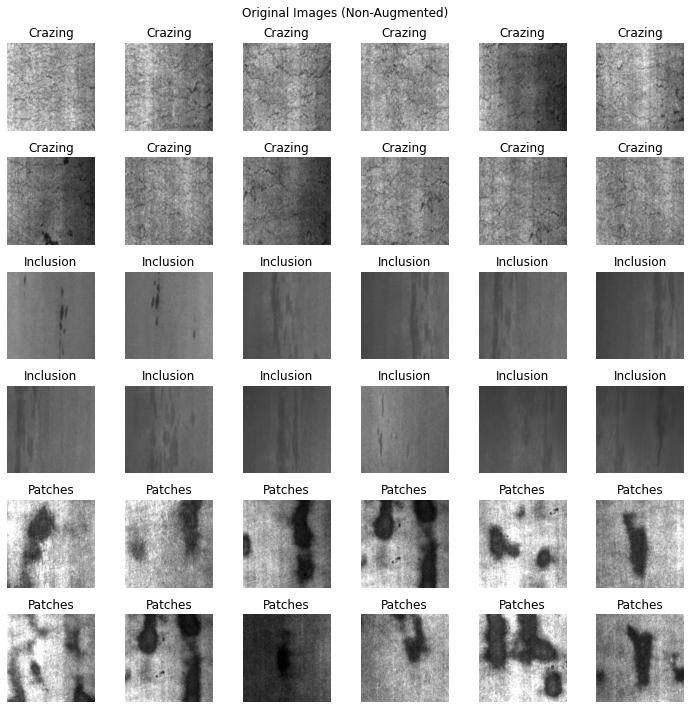

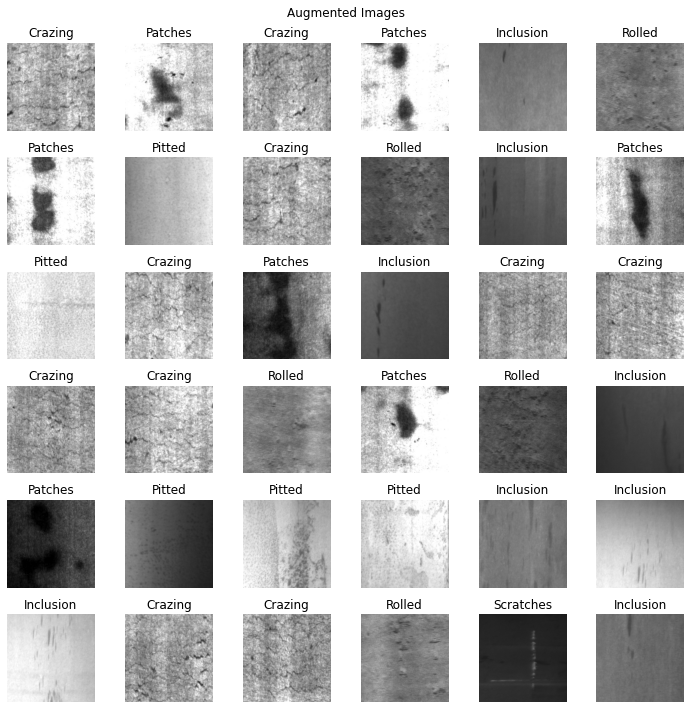

In [20]:
# Function to display images in a grid
def plot_images(images, labels, title, class_indices):
    plt.figure(figsize=(10, 10))
    for i in range(len(images)):
        plt.subplot(6, 6, i + 1)  # Adjust grid size if necessary
        plt.imshow(images[i])
        plt.title(class_indices[labels[i]])
        plt.axis('off')
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

# Plot original (non-augmented) images
original_images, original_labels = next(test_generator)  # Load a batch of original images
original_images = original_images[:36]  # Limit to 36 images
original_labels = np.argmax(original_labels[:36], axis=1)  # Decode one-hot labels
class_indices = {v: k for k, v in test_generator.class_indices.items()}  # Decode class indices

plot_images(
    original_images,
    original_labels,
    title="Original Images (Non-Augmented)",
    class_indices=class_indices
)

# Plot augmented images
augmented_images, augmented_labels = next(train_generator)  # Load a batch of augmented images
augmented_images = augmented_images[:36]  # Limit to 36 images
augmented_labels = np.argmax(augmented_labels[:36], axis=1)  # Decode one-hot labels

plot_images(
    augmented_images,
    augmented_labels,
    title="Augmented Images",
    class_indices=class_indices
)


Let's see the distribution of training dataset

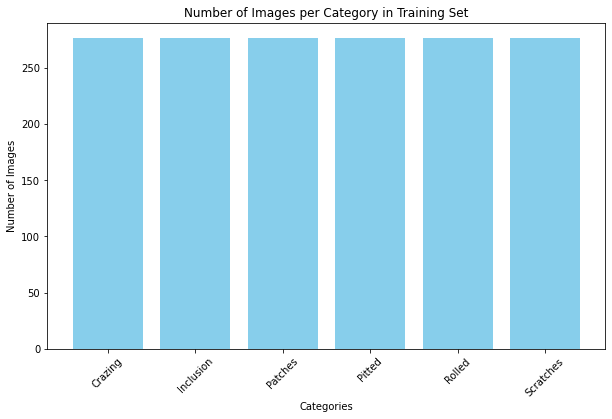

In [11]:
def count_images_per_category(directory):
    categories = os.listdir(directory)
    counts = Counter()
    
    for category in categories:
        category_path = os.path.join(directory, category)
        if os.path.isdir(category_path):
            num_images = len(os.listdir(category_path))
            counts[category] = num_images
    
    return counts

# Count the images in each category for the training set
train_counts = count_images_per_category(train_dir)
plt.figure(figsize=(10, 6))
plt.bar(train_counts.keys(), train_counts.values(), color='skyblue')
plt.xlabel('Categories')
plt.ylabel('Number of Images')
plt.title('Number of Images per Category in Training Set')
plt.xticks(rotation=45)
plt.show()

The dataset is balanced. All classes contains same number of images.

Let's confirm the batch size for images and labels in the training dataset.

In [5]:
for image_batch, labels_batch in train_generator:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(36, 200, 200, 3)
(36, 6)


Let's visualise some sample images from the training dataset. 

In [6]:
def get_sample_image(generator):
    images, labels = next(generator)
    image = images[0]
    label_index = np.argmax(labels[0])
    class_names=list(train_generator.class_indices.keys())
    label_name = class_names[label_index]

    return image, label_name


def sample_images(generator, nrows=4, ncols=4):
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 15))
    
    for i in range(nrows*ncols):
        image, label_name = get_sample_image(generator)
        row = i // ncols
        col = i % ncols
        ax = axes[row][col]
#         ax.imshow(image , cmap='gray_r')
        ax.imshow(image)
        ax.set_title(label_name)
        ax.axis('off')

    plt.show()

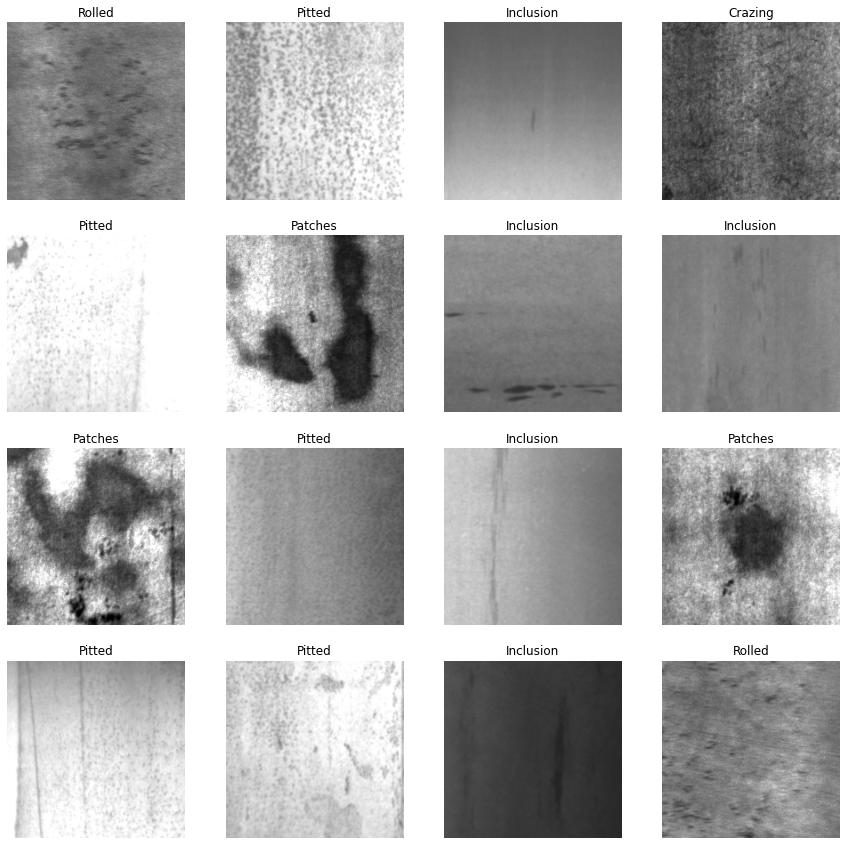

In [7]:
sample_images(train_generator, nrows=4, ncols=4)

Let's visualise the dataset in the reduced dimention(3 dimention) if the different categories of images are forming well separated clustes. Defining a function to extract features for visualisation through TSNE and PCA.

In [20]:
def extract_features(generator):
    features = []
    labels = []
    batches_processed = 0

    for inputs_batch, labels_batch in generator:
        features.append(inputs_batch)
        labels.append(labels_batch)
        batches_processed += 1
        
        # Check if all samples have been processed
        if batches_processed * generator.batch_size >= generator.samples:
            break

    # Stack features and labels
    features = np.vstack(features)
    labels = np.vstack(labels)
    
    print(f"Processed {batches_processed} batches.")
    print(f"Total features shape: {features.shape}")
    print(f"Total labels shape: {labels.shape}")
    
    return features, labels

# Extract features and labels from generators
train_features, train_labels = extract_features(train_generator)
validation_features, validation_labels = extract_features(valid_generator)
test_features, test_labels = extract_features(test_generator)

# Flatten the features for PCA and t-SNE
num_samples, height, width, channels = train_features.shape
flattened_features = train_features.reshape(num_samples, height * width * channels)

print(f"Shape of flattened_features: {flattened_features.shape}")
print(f"Shape of train_labels: {train_labels.shape}")

Processed 46 batches.
Total features shape: (1656, 200, 200, 3)
Total labels shape: (1656, 6)
Processed 2 batches.
Total features shape: (72, 200, 200, 3)
Total labels shape: (72, 6)
Processed 2 batches.
Total features shape: (72, 200, 200, 3)
Total labels shape: (72, 6)
Shape of flattened_features: (1656, 120000)
Shape of train_labels: (1656, 6)


Reducing the dimention of images using PCA and visualising in 3 dimention.

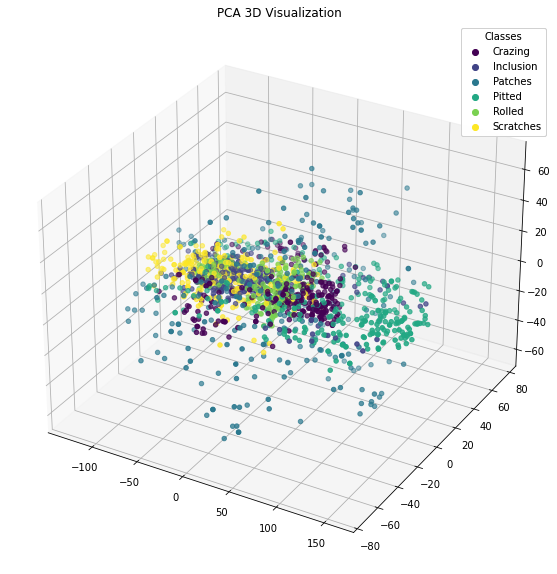

In [19]:
# PCA for 3D
class_names=list(train_generator.class_indices.keys())

pca = PCA(n_components=3)
reduced_features_3d = pca.fit_transform(flattened_features)

fig = plt.figure(figsize= (10,10))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(reduced_features_3d[:, 0], reduced_features_3d[:, 1], reduced_features_3d[:, 2], c=np.argmax(train_labels, axis=1), cmap='viridis')
# legend = ax.legend(*scatter.legend_elements(), title="Classes")
# ax.add_artist(legend)
handles, _ = scatter.legend_elements()
legend = ax.legend(handles, class_names, title="Classes")
ax.add_artist(legend)
plt.title('PCA 3D Visualization')
plt.show()


* Classes like "Crazing," "Inclusion," "Patches," "Pitted," "Rolled," and "Scratches" do not seem to form well-separated clusters, which may imply that they share similar visual features or are difficult to distinguish based on the features captured by PCA
* The high degree of overlap suggests that a simple classification model might struggle to differentiate these classes based on this feature space. Complex models such as convolutional neural networks (CNNs) may perform better.

Visualising in 3d using tsne dimentional reduction technique t-SNE(Non- Linear Dimentionality reduction)

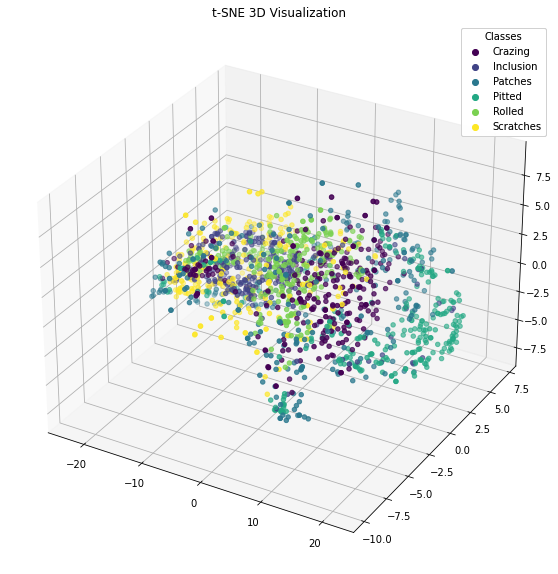

In [21]:
# t-SNE for 3D
tsne = TSNE(n_components=3, random_state=42)
tsne_features_3d = tsne.fit_transform(flattened_features)

fig = plt.figure(figsize= (10,10))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(tsne_features_3d[:, 0], tsne_features_3d[:, 1], tsne_features_3d[:, 2], c=np.argmax(train_labels, axis=1), cmap='viridis')
# legend = ax.legend(*scatter.legend_elements(), title="Classes")
# ax.add_artist(legend)
handles, _ = scatter.legend_elements()
legend = ax.legend(handles, class_names, title="Classes")
ax.add_artist(legend)
plt.title('t-SNE 3D Visualization')
plt.show()

* Some classes appear to be more distinctly separated (for example, "Scratches" in yellow) seems to have a degree of separation from others, there are other classes that may show overlap, indicating that some features between these classes may be similar or harder to distinguish

Creating a simple CNN model for classification

In [7]:
# Model layers
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(200, 200, 3)),
#     BatchNormalization(),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
#     BatchNormalization(),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
#     BatchNormalization(),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
#     Dense(64, activation='relu'),
#     Dropout(0.3),
    Dense(6 ,activation='softmax')
])

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 198, 198, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 99, 99, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 97, 97, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 48, 48, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 46, 46, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 23, 23, 128)      0

In [16]:
plot_model(model, to_file="model_architecture.png", show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [25]:
checkpoint_cb = ModelCheckpoint(
    filepath='second/model_checkpoint_final5.h5', 
    save_best_only=True, 
    monitor='val_loss', 
    mode='min', 
    verbose=1
)

# Early stopping callback to stop training when validation loss stops improving
early_stopping_cb = EarlyStopping(
    monitor='val_loss', 
    patience=10, 
    restore_best_weights=True, 
    verbose=1
)

# Reduce learning rate when a metric has stopped improving
reduce_lr_cb = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.2, 
    patience=5, 
    min_lr=0.0001, 
    verbose=1
)

# List of callbacks
callbacks = [checkpoint_cb, early_stopping_cb, reduce_lr_cb]

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model with callbacks
history = model.fit(
    train_generator,
    epochs=25,
    validation_data=valid_generator,
    callbacks=callbacks
)

Epoch 1/25
46/46 [==============================] - ETA: 0s - loss: 1.6483 - accuracy: 0.2947
Epoch 1: val_loss improved from inf to 1.13976, saving model to second\model_checkpoint_final5.h5
46/46 [==============================] - 58s 1s/step - loss: 1.6483 - accuracy: 0.2947 - val_loss: 1.1398 - val_accuracy: 0.6111 - lr: 0.0010
Epoch 2/25
46/46 [==============================] - ETA: 0s - loss: 0.9465 - accuracy: 0.6214
Epoch 2: val_loss improved from 1.13976 to 0.55424, saving model to second\model_checkpoint_final5.h5
46/46 [==============================] - 39s 843ms/step - loss: 0.9465 - accuracy: 0.6214 - val_loss: 0.5542 - val_accuracy: 0.8750 - lr: 0.0010
Epoch 3/25
46/46 [==============================] - ETA: 0s - loss: 0.6228 - accuracy: 0.7772
Epoch 3: val_loss improved from 0.55424 to 0.28662, saving model to second\model_checkpoint_final5.h5
46/46 [==============================] - 38s 818ms/step - loss: 0.6228 - accuracy: 0.7772 - val_loss: 0.2866 - val_accuracy: 0.91

Saving the model using pickle

In [12]:
# Save the model
# with open('second/cnn_model.pkl', 'wb') as f:
#     pickle.dump(model, f)

# Load the model
# with open('svm_model.pkl', 'rb') as f:
#     loaded_svm_model = pickle.load(f)

# best_model = load_model('model_checkpoint.h5')
# best_model2 = load_model('model_checkpoint_final.h5')
# best_model3 = load_model('model_checkpoint_final3.h5')
# best_model4 = load_model('model_checkpoint_final4.h5')
best_model5 = load_model('second/model_checkpoint_final5.h5')

We have now trained the model. We saw that the PCA and TSNE of the original images didn't show any aggregation of the different image classes. Now lets pass the images through the CNN model and take the output from the second last layer and see how well the model has learned different class embeddings.

In [11]:
best_model5.layers[-3]

In [21]:
# Extract features from the second last layer
feature_model = Model(inputs=best_model5.input, outputs=best_model5.layers[-2].output)
X_features = feature_model.predict(train_features)

52/52 [==============================] - 23s 426ms/step


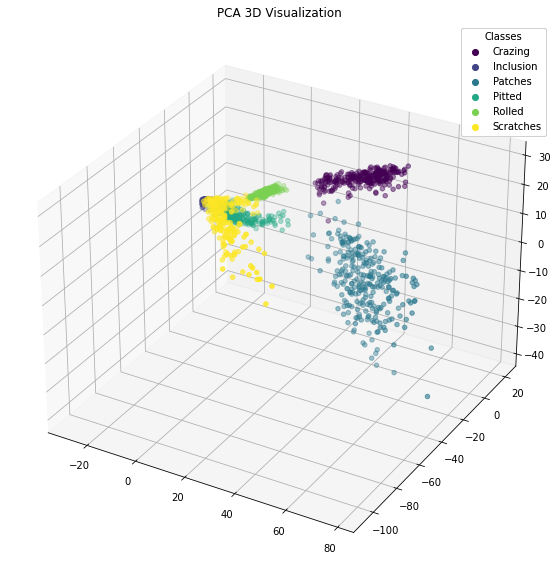

In [25]:
# PCA for 3D
class_names=list(train_generator.class_indices.keys())

pca = PCA(n_components=3)
reduced_features_3d = pca.fit_transform(X_features)

fig = plt.figure(figsize= (10,10))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(reduced_features_3d[:, 0], reduced_features_3d[:, 1], reduced_features_3d[:, 2], c=np.argmax(train_labels, axis=1), cmap='viridis')
# legend = ax.legend(*scatter.legend_elements(), title="Classes")
# ax.add_artist(legend)
handles, _ = scatter.legend_elements()
legend = ax.legend(handles, class_names, title="Classes")
ax.add_artist(legend)
plt.title('PCA 3D Visualization')
plt.show()


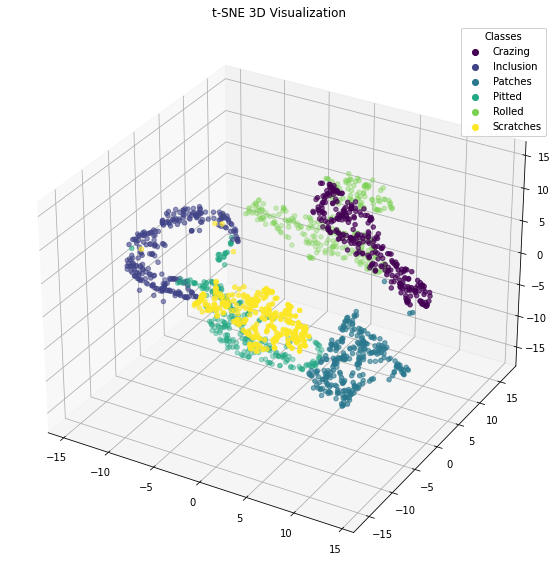

In [24]:
# t-SNE for 3D
tsne = TSNE(n_components=3, random_state=42)
tsne_features_3d = tsne.fit_transform(X_features)

fig = plt.figure(figsize= (10,10))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(tsne_features_3d[:, 0], tsne_features_3d[:, 1], tsne_features_3d[:, 2], c=np.argmax(train_labels, axis=1), cmap='viridis')
# legend = ax.legend(*scatter.legend_elements(), title="Classes")
# ax.add_artist(legend)
handles, _ = scatter.legend_elements()
legend = ax.legend(handles, class_names, title="Classes")
ax.add_artist(legend)
plt.title('t-SNE 3D Visualization')
plt.show()

Let's also see the feature map of an image by extracting the output from all the convolution and maxpooling layers of the CNN model

Original image shape: (200, 200)
1/1 [==============================] - 0s 130ms/step


C:\Users\shri\AppData\Local\Temp\ipykernel_35400\1068220033.py:40: RuntimeWarning: invalid value encountered in divide
  x /= x.std()
C:\Users\shri\AppData\Local\Temp\ipykernel_35400\1068220033.py:43: RuntimeWarning: invalid value encountered in cast
  x = np.clip(x, 0, 255).astype('uint8')


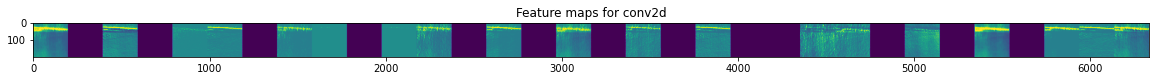

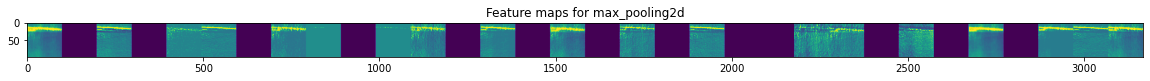

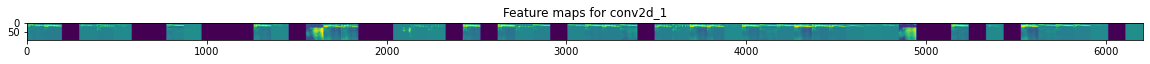

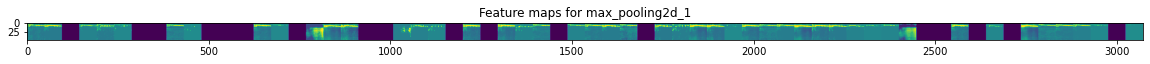

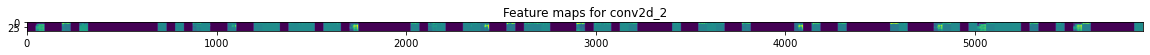

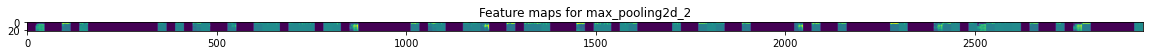

In [13]:
# Define a new model to extract feature maps from the convolutional layers
layer_outputs = [layer.output for layer in best_model5.layers[:6]]  # Extract outputs from the first 6 layers (conv + pooling)
feature_map_model = Model(inputs=best_model5.input, outputs=layer_outputs)

# Select a misclassified image
# misclassified_index = misclassified_indices[0]  # Choose the first misclassified image
img_path = test_generator.filepaths[69]
img = plt.imread(img_path)

# Check the image shape
print("Original image shape:", img.shape)  # Should be (200, 200, 3) for RGB or (200, 200) for grayscale

# If the image is grayscale (2D), convert it to RGB (3D)
if len(img.shape) == 2:
    img = np.stack((img,) * 3, axis=-1)  # Convert grayscale to RGB by repeating the channel

# Add batch dimension and normalize pixel values
img = np.expand_dims(img, axis=0)  # Shape: (1, 200, 200, 3)
img = img / 255.0  # Normalize pixel values (if not already done)

# Get the feature maps for the misclassified image
feature_maps = feature_map_model.predict(img)

# Visualize the feature maps
layer_names = [layer.name for layer in best_model5.layers[:6]]  # Names of the first 6 layers

for layer_name, feature_map in zip(layer_names, feature_maps):
    if len(feature_map.shape) == 4:  # Check if the layer output is a feature map (4D tensor)
        num_filters = feature_map.shape[-1]  # Number of filters in the layer
        size = feature_map.shape[1]  # Size of the feature map (width/height)
        
        # Display the feature maps in a grid
        display_grid = np.zeros((size, size * num_filters))
        
        for i in range(num_filters):
            # Post-process each filter to make it visually interpretable
#             x = feature_map[0, :, :, i]
            x = feature_map[0, :, :, i]
            x -= x.mean()
            x /= x.std()
            x *= 64
            x += 128
            x = np.clip(x, 0, 255).astype('uint8')
            
            # Place each filter in the grid
            display_grid[:, i * size : (i + 1) * size] = x
        
        # Plot the feature maps
        scale = 20. / num_filters
#         plt.figure(figsize=(16, 2))
        plt.figure(figsize=(scale * num_filters, scale))
        plt.title(f"Feature maps for {layer_name}")
        plt.grid(False)
        plt.imshow(display_grid, aspect='auto', cmap='viridis')
        plt.show()

Because we have high CNN kernels, it is not very clear to view all the kernels in the same plot, let's only vies only 16 kernels for a better understanding.

Original image shape: (200, 200)
1/1 [==============================] - 0s 68ms/step


C:\Users\shri\AppData\Local\Temp\ipykernel_35400\1078273471.py:40: RuntimeWarning: invalid value encountered in divide
  x /= x.std()
C:\Users\shri\AppData\Local\Temp\ipykernel_35400\1078273471.py:43: RuntimeWarning: invalid value encountered in cast
  x = np.clip(x, 0, 255).astype('uint8')


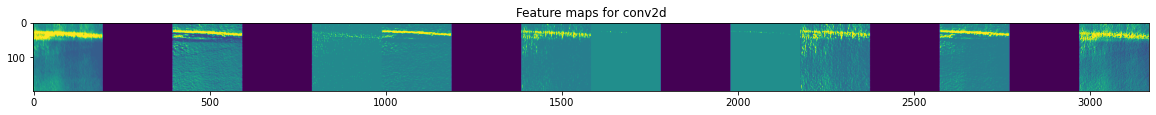

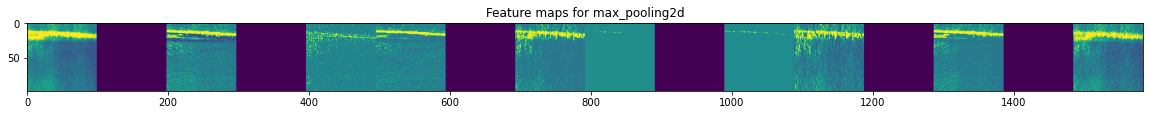

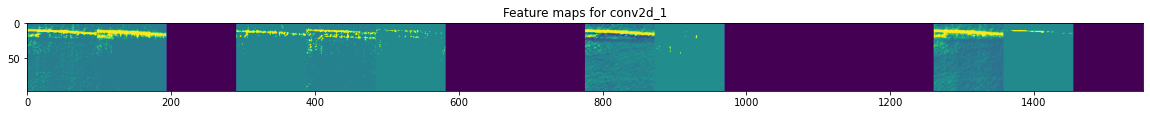

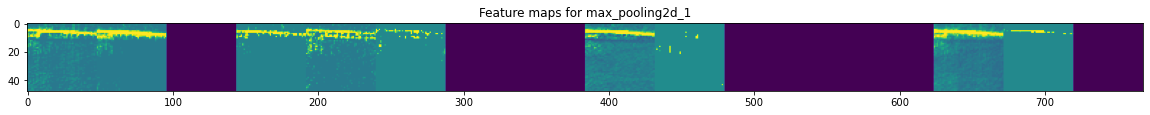

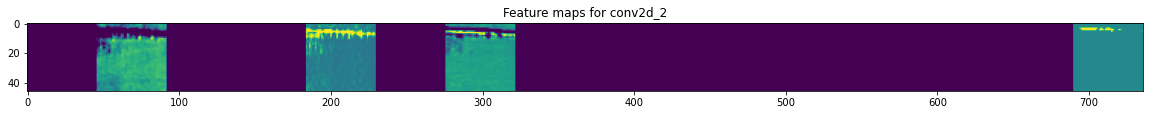

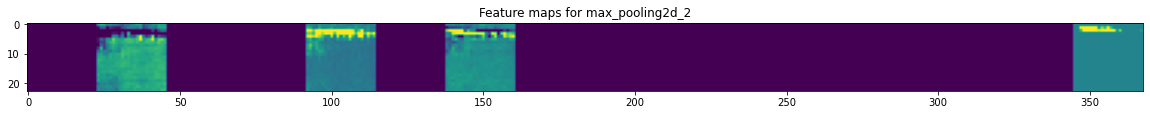

In [14]:
# Define a new model to extract feature maps from the convolutional layers
layer_outputs = [layer.output for layer in best_model5.layers[:6]]  # Extract outputs from the first 6 layers (conv + pooling)
feature_map_model = Model(inputs=best_model5.input, outputs=layer_outputs)

# Select a misclassified image
# misclassified_index = misclassified_indices[0]  # Choose the first misclassified image
img_path = test_generator.filepaths[69]
img = plt.imread(img_path)

# Check the image shape
print("Original image shape:", img.shape)  # Should be (200, 200, 3) for RGB or (200, 200) for grayscale

# If the image is grayscale (2D), convert it to RGB (3D)
if len(img.shape) == 2:
    img = np.stack((img,) * 3, axis=-1)  # Convert grayscale to RGB by repeating the channel

# Add batch dimension and normalize pixel values
img = np.expand_dims(img, axis=0)  # Shape: (1, 200, 200, 3)
img = img / 255.0  # Normalize pixel values (if not already done)

# Get the feature maps for the misclassified image
feature_maps = feature_map_model.predict(img)

# Visualize the feature maps
layer_names = [layer.name for layer in best_model5.layers[:6]]  # Names of the first 6 layers

for layer_name, feature_map in zip(layer_names, feature_maps):
    if len(feature_map.shape) == 4:  # Check if the layer output is a feature map (4D tensor)
        num_filters = 16  # Number of filters in the layer
        size = feature_map.shape[1]  # Size of the feature map (width/height)
        
        # Display the feature maps in a grid
        display_grid = np.zeros((size, size * num_filters))
        
        for i in range(num_filters):
            # Post-process each filter to make it visually interpretable
#             x = feature_map[0, :, :, i]
            x = feature_map[0, :, :, i]
            x -= x.mean()
            x /= x.std()
            x *= 64
            x += 128
            x = np.clip(x, 0, 255).astype('uint8')
            
            # Place each filter in the grid
            display_grid[:, i * size : (i + 1) * size] = x
        
        # Plot the feature maps
        scale = 20. / num_filters
#         plt.figure(figsize=(16, 2))
        plt.figure(figsize=(scale * num_filters, scale))
        plt.title(f"Feature maps for {layer_name}")
        plt.grid(False)
        plt.imshow(display_grid, aspect='auto', cmap='viridis')
        plt.show()

We can see that the model has learned some nice class embeddings.

In [33]:
 def plot_history(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric], '')
    plt.xlabel('Epochs')
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])
    plt.show()

Plotting accuracies and loss for CNN model

In [36]:
# plot_history(history, 'accuracy')

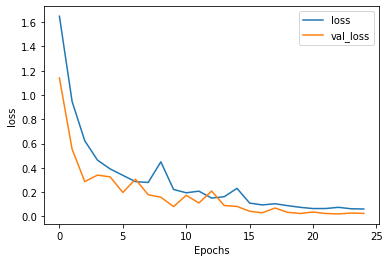

In [33]:
plot_history(history, 'loss')

Let's see the performance of CNN model on test dataset

In [35]:
result = best_model5.evaluate(test_generator)
print("Test loss, Test accuracy : ", result)

2/2 [==============================] - 1s 442ms/step - loss: 0.0730 - accuracy: 0.9583
Test loss, Test accuracy :  [0.07299066334962845, 0.9583333134651184]


In [39]:
# Generate predictions on the test data
test_generator.reset()  # Ensure the generator starts from the beginning
predictions = best_model5.predict(test_generator, steps=test_generator.n // test_generator.batch_size + 1)
predicted_classes = np.argmax(predictions, axis=1)  # Convert probabilities to class predictions
true_classes = test_generator.classes  # True labels
class_labels = list(test_generator.class_indices.keys())  # Class names

# Step 2: Classification Report
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print("Classification Report:")
print(report)


3/3 [==============================] - 0s 110ms/step
Classification Report:
              precision    recall  f1-score   support

     Crazing       1.00      1.00      1.00        12
   Inclusion       0.86      1.00      0.92        12
     Patches       1.00      1.00      1.00        12
      Pitted       0.91      0.83      0.87        12
      Rolled       1.00      1.00      1.00        12
   Scratches       1.00      0.92      0.96        12

    accuracy                           0.96        72
   macro avg       0.96      0.96      0.96        72
weighted avg       0.96      0.96      0.96        72



Let's see the actual and predicted labels of the few test images.

1/1 [==============================] - 0s 144ms/step


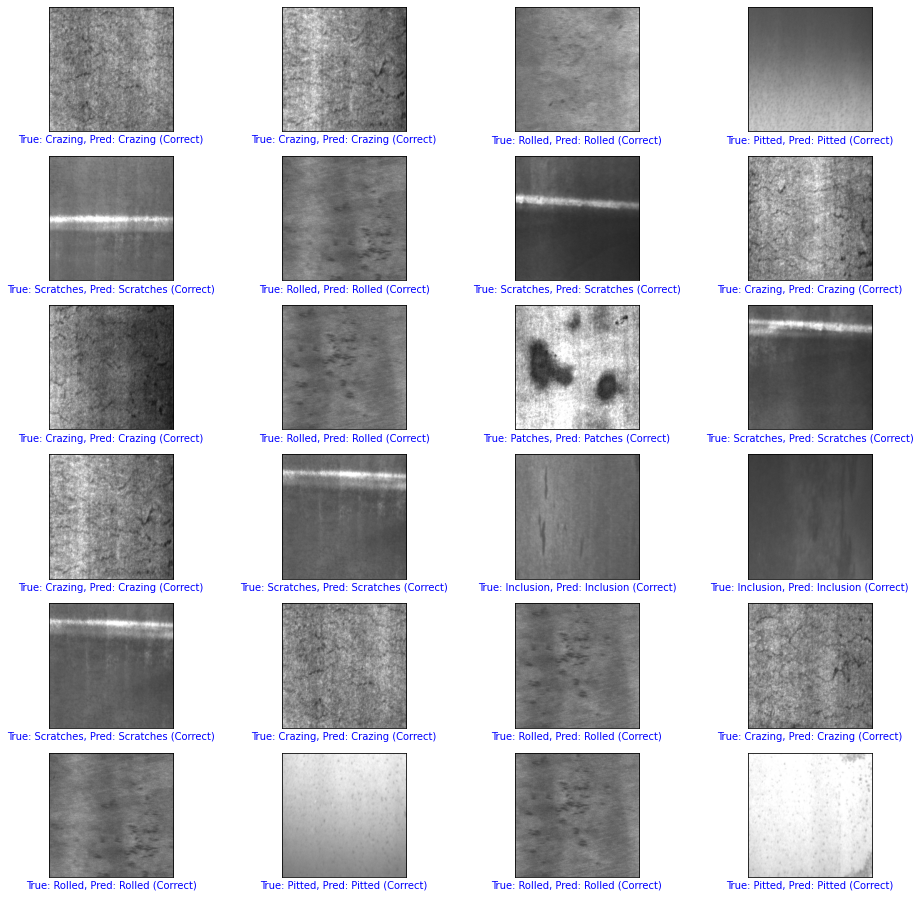

In [54]:
images, labels = next(test_generator)    

indices = np.random.choice(range(len(images)), size=24)
images = images[indices]
labels = labels[indices]

predictions = best_model5.predict(images)


class_names=list(test_generator.class_indices.keys())


plt.figure(figsize=(16,16))
    
for i in range(24):
    plt.subplot(6,4,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
        
    image = images[i]
        
    if image.shape[-1] == 1:
        image = np.squeeze(image) 
        
    plt.imshow(image)
        
    predicted_label = np.argmax(predictions[i])
        
    if predicted_label == np.argmax(labels[i]):
        color='blue'
        result_text="Correct"
            
    else:
        color='red'
        result_text="Incorrect"

    label_text="True: "+ class_names[np.argmax(labels[i])] + ", Pred: " + class_names[predicted_label] + f" ({result_text})"        
            
    plt.xlabel(label_text,color=color)


Let's see the missclassified images

2/2 [==============================] - 0s 176ms/step


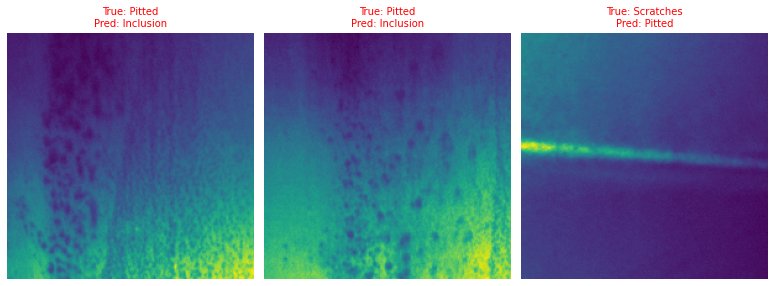

In [9]:
# Get class labels
class_labels = list(test_generator.class_indices.keys())

# Make predictions
predictions = best_model5.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes

# Find misclassified images
misclassified_indices = np.where(predicted_classes != true_classes)[0]

# Display some misclassified images
num_images = min(10, len(misclassified_indices))  # Show up to 10 images
plt.figure(figsize=(18, 9))

for i, index in enumerate(misclassified_indices[:num_images]):
    img_path = test_generator.filepaths[index]
    img = plt.imread(img_path)
    
    true_label = class_labels[true_classes[index]]
    pred_label = class_labels[predicted_classes[index]]

    plt.subplot(2, 5, i + 1)
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"True: {true_label}\nPred: {pred_label}", fontsize=10, color="red")

plt.tight_layout()
plt.show()


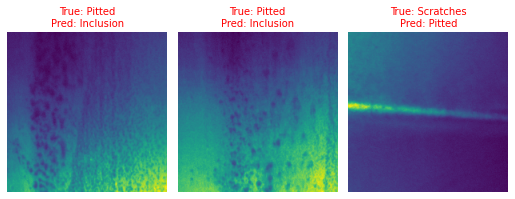

In [8]:
# Find misclassified images
misclassified_indices = np.where(true_classes != predicted_classes)[0]

# Display some misclassified images
num_images = min(10, len(misclassified_indices))  # Show up to 10 images
plt.figure(figsize=(12, 6))

for i, index in enumerate(misclassified_indices[:num_images]):
    img_path = test_generator.filepaths[index]
    img = plt.imread(img_path)
    
    true_label = class_labels[true_classes[index]]
    pred_label = class_labels[predicted_classes[index]]

    plt.subplot(2, 5, i + 1)
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"True: {true_label}\nPred: {pred_label}", fontsize=10, color="red")

plt.tight_layout()
plt.show()


2/2 [==============================] - 1s 386ms/step


C:\Users\shri\AppData\Local\Temp\ipykernel_35400\1397582490.py:17: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(reduced_features_2d[misclassified_indices, 0],


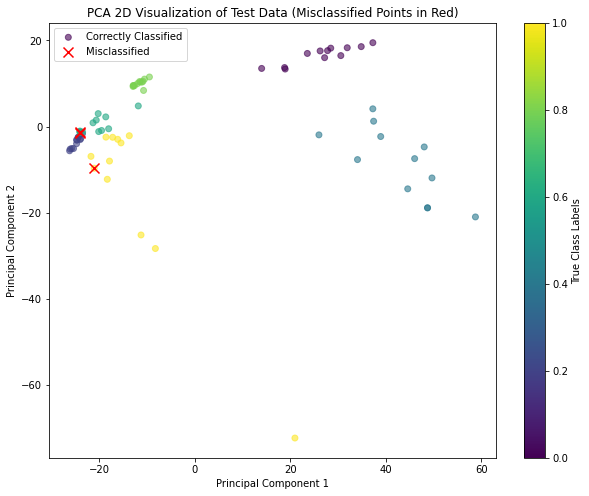

In [15]:
## delete these if does not worksimport numpy as np

# Extract features for test data
feature_model = Model(inputs=best_model5.input, outputs=best_model5.layers[-2].output)
X_test_features = feature_model.predict(test_generator)

# Apply PCA to reduce features to 2D
pca = PCA(n_components=2)
reduced_features_2d = pca.fit_transform(X_test_features)

# Identify misclassified points
misclassified_indices = np.where(predicted_classes != true_classes)[0]

# Plot PCA visualization
plt.figure(figsize=(10, 8))
scatter = plt.scatter(reduced_features_2d[:, 0], reduced_features_2d[:, 1], c=true_classes, cmap='viridis', alpha=0.6, label="Correctly Classified")
plt.scatter(reduced_features_2d[misclassified_indices, 0], 
            reduced_features_2d[misclassified_indices, 1], 
            c='red', edgecolors='k', marker='x', s=100, label="Misclassified")

# Add legend and labels
plt.legend()
plt.colorbar(label="True Class Labels")
plt.title("PCA 2D Visualization of Test Data (Misclassified Points in Red)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()


2/2 [==============================] - 0s 203ms/step


C:\Users\shri\AppData\Local\Temp\ipykernel_35400\700548598.py:17: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(reduced_features_tsne[misclassified_indices, 0],


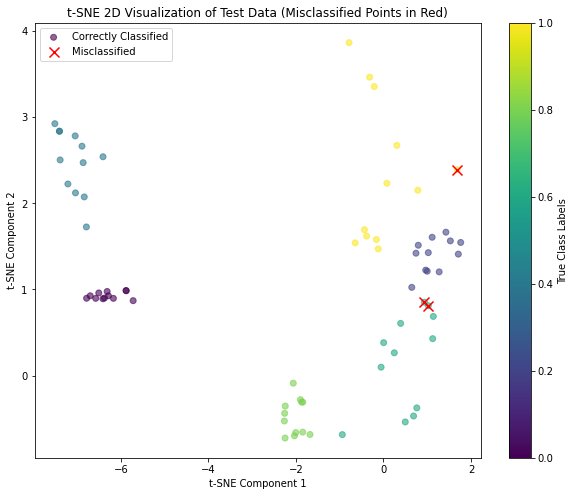

In [16]:
# Extract features for test data
feature_model = Model(inputs=best_model5.input, outputs=best_model5.layers[-2].output)
X_test_features = feature_model.predict(test_generator)

# Apply t-SNE for 2D visualization
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
reduced_features_tsne = tsne.fit_transform(X_test_features)

# Identify misclassified points
misclassified_indices = np.where(predicted_classes != true_classes)[0]

# Plot t-SNE visualization
plt.figure(figsize=(10, 8))
scatter = plt.scatter(reduced_features_tsne[:, 0], reduced_features_tsne[:, 1], c=true_classes, cmap='viridis', alpha=0.6, label="Correctly Classified")

# Highlight misclassified images in red
plt.scatter(reduced_features_tsne[misclassified_indices, 0], 
            reduced_features_tsne[misclassified_indices, 1], 
            c='red', edgecolors='k', marker='x', s=100, label="Misclassified")

# Add legend and labels
plt.legend()
plt.colorbar(label="True Class Labels")
plt.title("t-SNE 2D Visualization of Test Data (Misclassified Points in Red)")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.show()


Lets plot a confusion matrix.

2/2 [==============================] - 1s 457ms/step


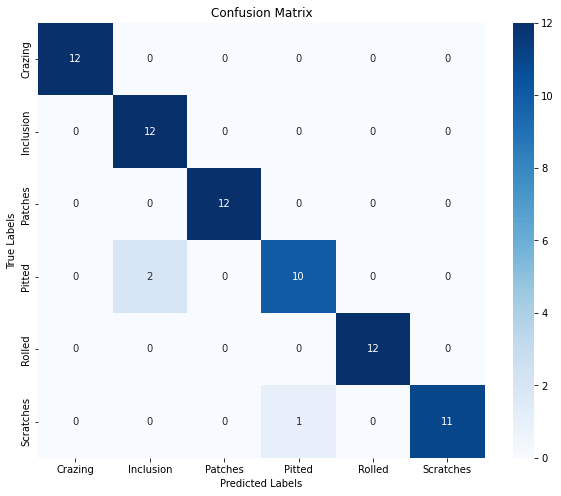

In [43]:
predictions = best_model5.predict(test_generator, verbose=1)

# Step 2: Convert Predictions to Class Labels
predicted_classes = np.argmax(predictions, axis=1)  # Get class with the highest probability
true_classes = test_generator.classes  # True labels from the generator
class_labels = list(test_generator.class_indices.keys())  # Class names

# Step 3: Generate Confusion Matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Step 4: Display Confusion Matrix as Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()


In the context of identifying sheet metal defects, CNNs are particularly effective due to their innate ability to learn complex hierarchies of visual features. By employing convolutional layers, CNNs are able to capture relevant local patterns, making them ideal for detecting visual defects such as scratches, cracks, and surface irregularities, features that are crucial for automated visual inspection.

Let's also train few simpler models like non linear SVM molde on our dataset to see its performance.

Preparing the dataset for training and inference

In [18]:
def produce_image_labels(dir):
    # Loop through each subdirectory in the root directory
    # Lists to store the features and labels
    images = []
    labels = []
    list_dir = os.listdir(dir)
    for subdirectory in list_dir:
        # Check if it is a subdirectory
        if os.path.isdir(os.path.join(dir, subdirectory)):
            # Get the full path to the subdirectory
            subdirectory_path = os.path.join(dir, subdirectory)
        
            # Loop through each image in the subdirectory
            for image_name in os.listdir(subdirectory_path):
            # Get the full path to the image
                image_path = os.path.join(subdirectory_path, image_name)
            
                # Load the image
                image = io.imread(image_path)
            
                # Apply HOG (Histogram of Oriented Gradients) to extract features
                features_hog, _ = feature.hog(image, visualize=True)
            
                # Add the features and label to the lists
                images.append(features_hog)
                labels.append(subdirectory)

    # Convert the lists to NumPy arrays
    images = np.array(images)
    labels = np.array(labels)
    return images,labels

train_images ,train_labels = produce_image_labels(train_dir)
print("Done")
val_images ,val_labels = produce_image_labels(valid_dir)
print("Done")
test_images ,test_labels = produce_image_labels(test_dir)


Done
Done


For non-linearity we are using radial basis function kernel. Also concatinating train and validation data to have more data for training

In [35]:
combined_images = np.concatenate([train_images, val_images])
combined_labels = np.concatenate([train_labels, val_labels])

In [36]:
# Train SVM on the combined data
svm_model_final = SVC(kernel='rbf', gamma='scale', C=1.0)
svm_model_final.fit(combined_images, combined_labels)


SVC()

In [38]:
test_predictions = svm_model_final.predict(test_images)
test_accuracy = accuracy_score(test_labels, test_predictions)

# print(f'Validation Accuracy: {validation_accuracy}')
print(f'Test Accuracy: {test_accuracy}')

Test Accuracy: 0.8055555555555556


Our SVM model also performance is descent. We can tune gama and c hyperparameters to improve the performance but we will leave it here.

Let's see the confusion matrix of our svm test data prediction

Confusion matrix, without normalization
[[12  0  0  0  0  0]
 [ 0 11  0  1  0  0]
 [ 0  0 12  0  0  0]
 [ 1  3  1  5  0  2]
 [ 0  0  0  0 12  0]
 [ 0  1  4  0  0  7]]


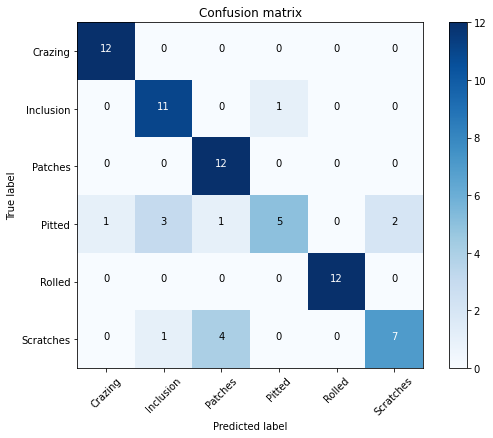

In [9]:
class_names=list(test_generator.class_indices.keys())
# Calculate the confusion matrix
svm_confusion_matrix = confusion_matrix(test_labels, test_predictions)

# Function to plot the confusion matrix
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
plot_confusion_matrix(svm_confusion_matrix, class_names)
plt.show()

## Random Forest

In [31]:
# Define hyperparameter grid
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

# Grid search
rf_model = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(combined_images, combined_labels)

# Best parameters
print("Best Hyperparameters:", grid_search.best_params_)
best_rf_model = grid_search.best_estimator_


Fitting 3 folds for each of 108 candidates, totalling 324 fits
Best Hyperparameters: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 200}


In [47]:
rf_model_2 = RandomForestClassifier(
    n_estimators=200,
    max_depth=20,
    min_samples_split=10,
    min_samples_leaf=2,
    max_features='sqrt',
    random_state=42
)
rf_model_2.fit(train_images, train_labels)

# Evaluate
test_predictions_rf = rf_model_2.predict(test_images)
test_accuracy = accuracy_score(test_labels, test_predictions)
print(f"Test Accuracy: {test_accuracy}")

Test Accuracy: 0.8055555555555556


Confusion matrix, without normalization
[[ 9  0  3  0  0  0]
 [ 0  9  1  2  0  0]
 [ 3  0  6  3  0  0]
 [ 0  4  2  4  0  2]
 [ 0  0  0  0 12  0]
 [ 1  1  0  2  1  7]]


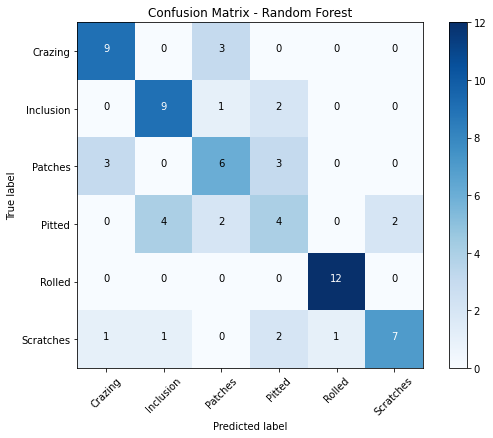

In [48]:
# Plot the Random Forest confusion matrix
confusion_matrix_rf = confusion_matrix(test_labels, test_predictions_rf)

plt.figure(figsize=(8, 6))
plot_confusion_matrix(confusion_matrix_rf, class_names)
plt.title('Confusion Matrix - Random Forest')
plt.show()

# Model Comparison

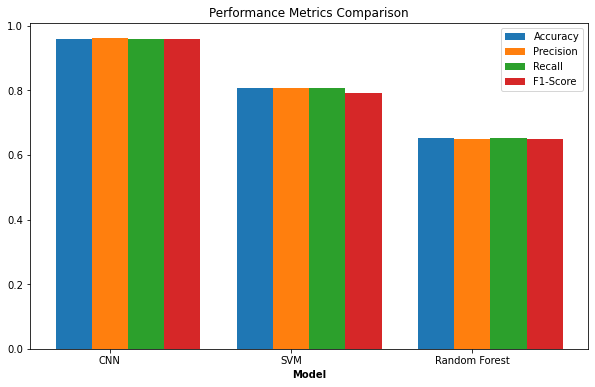

In [51]:
accuracy_cnn = accuracy_score(true_classes, predicted_classes)
precision_cnn = precision_score(true_classes, predicted_classes, average='weighted')
recall_cnn = recall_score(true_classes, predicted_classes, average='weighted')
f1_cnn = f1_score(true_classes, predicted_classes, average='weighted')

# print(f'CNN Accuracy: {accuracy_cnn:.2f}')
# print(f'CNN Precision: {precision_cnn:.2f}')
# print(f'CNN Recall: {recall_cnn:.2f}')
# print(f'CNN F1-Score: {f1_cnn:.2f}')

accuracy_svm = accuracy_score(test_labels, test_predictions)
precision_svm = precision_score(test_labels, test_predictions, average='weighted')
recall_svm = recall_score(test_labels, test_predictions, average='weighted')
f1_svm = f1_score(test_labels, test_predictions, average='weighted')

# print(f'SVM Accuracy: {accuracy_svm:.2f}')
# print(f'SVM Precision: {precision_svm:.2f}')
# print(f'SVM Recall: {recall_svm:.2f}')
# print(f'SVM F1-Score: {f1_svm:.2f}')

accuracy_rf = accuracy_score(test_labels, test_predictions_rf)
precision_rf = precision_score(test_labels, test_predictions_rf, average='weighted')
recall_rf = recall_score(test_labels, test_predictions_rf, average='weighted')
f1_rf = f1_score(test_labels, test_predictions_rf, average='weighted')

# print(f'Random Forest Accuracy: {accuracy_rf:.2f}')
# print(f'Random Forest Precision: {precision_rf:.2f}')
# print(f'Random Forest Recall: {recall_rf:.2f}')
# print(f'Random Forest F1-Score: {f1_rf:.2f}')

models = ['CNN', 'SVM', 'Random Forest']
accuracies = [accuracy_cnn, accuracy_svm, accuracy_rf]
precisions = [precision_cnn, precision_svm, precision_rf]
recalls = [recall_cnn, recall_svm, recall_rf]
f1_scores = [f1_cnn, f1_svm, f1_rf]

barWidth = 0.2
r1 = np.arange(len(accuracies))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
r4 = [x + barWidth for x in r3]

plt.figure(figsize=(10, 6))

plt.bar(r1, accuracies, width=barWidth, label='Accuracy')
plt.bar(r2, precisions, width=barWidth, label='Precision')
plt.bar(r3, recalls, width=barWidth, label='Recall')
plt.bar(r4, f1_scores, width=barWidth, label='F1-Score')

plt.xlabel('Model', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(accuracies))], models)
plt.title('Performance Metrics Comparison')
plt.legend()

plt.show()

Our model are generally confused between two sets of images Scratches with Patches and Pitted with inclusion. Let's visualise them side by side to see if they are similar to each other.

Visualizing Pitted vs Inclusion...


<Figure size 864x576 with 0 Axes>

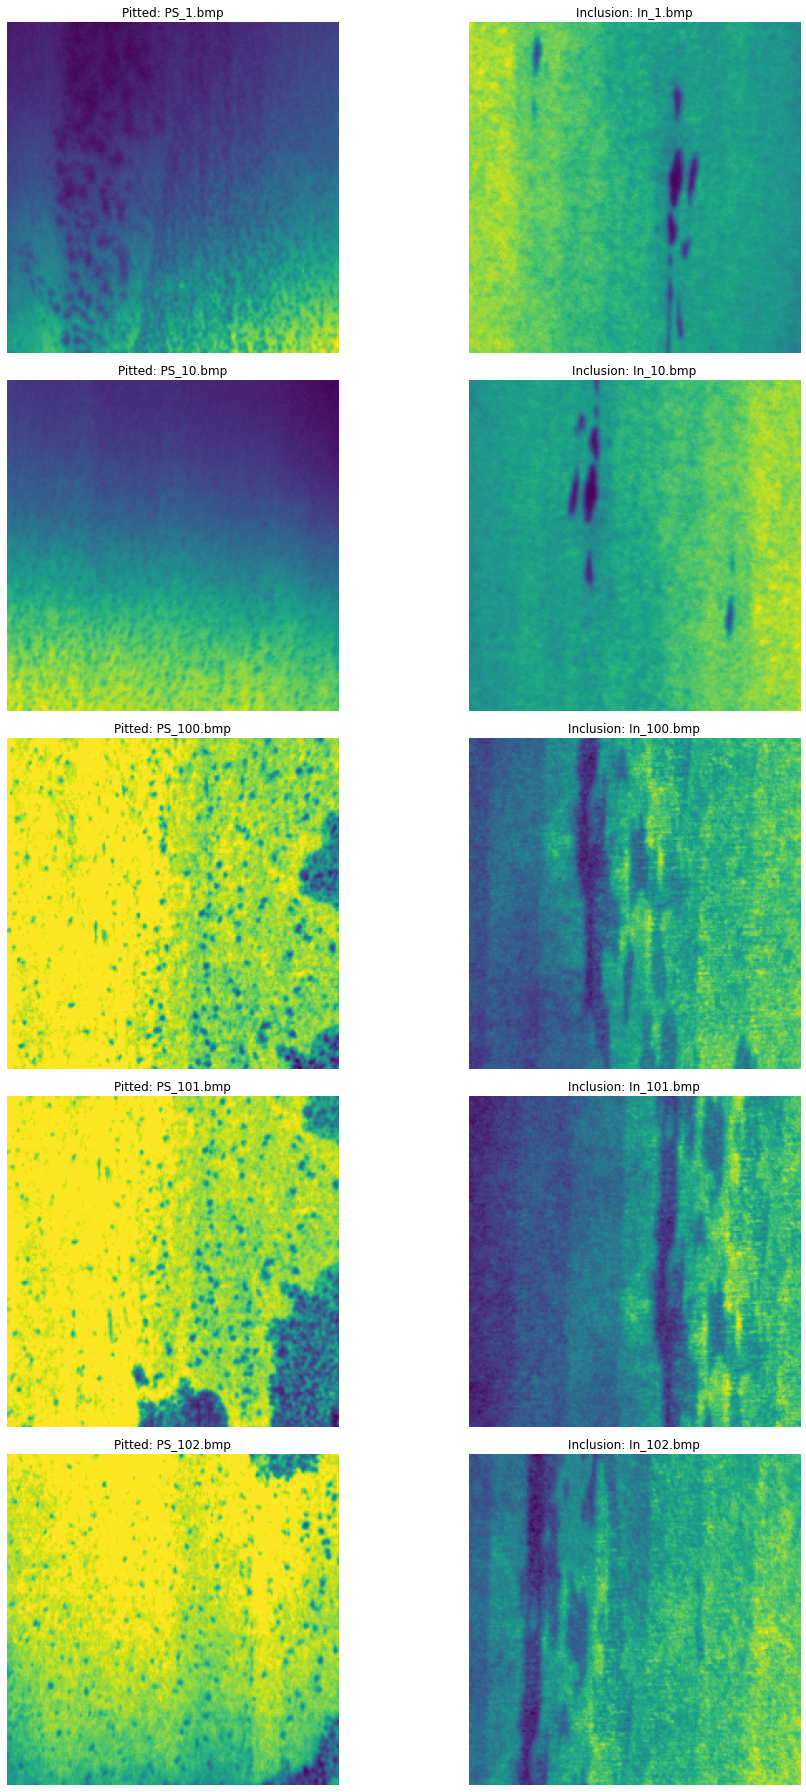

Visualizing Scratches vs Patches...


<Figure size 864x576 with 0 Axes>

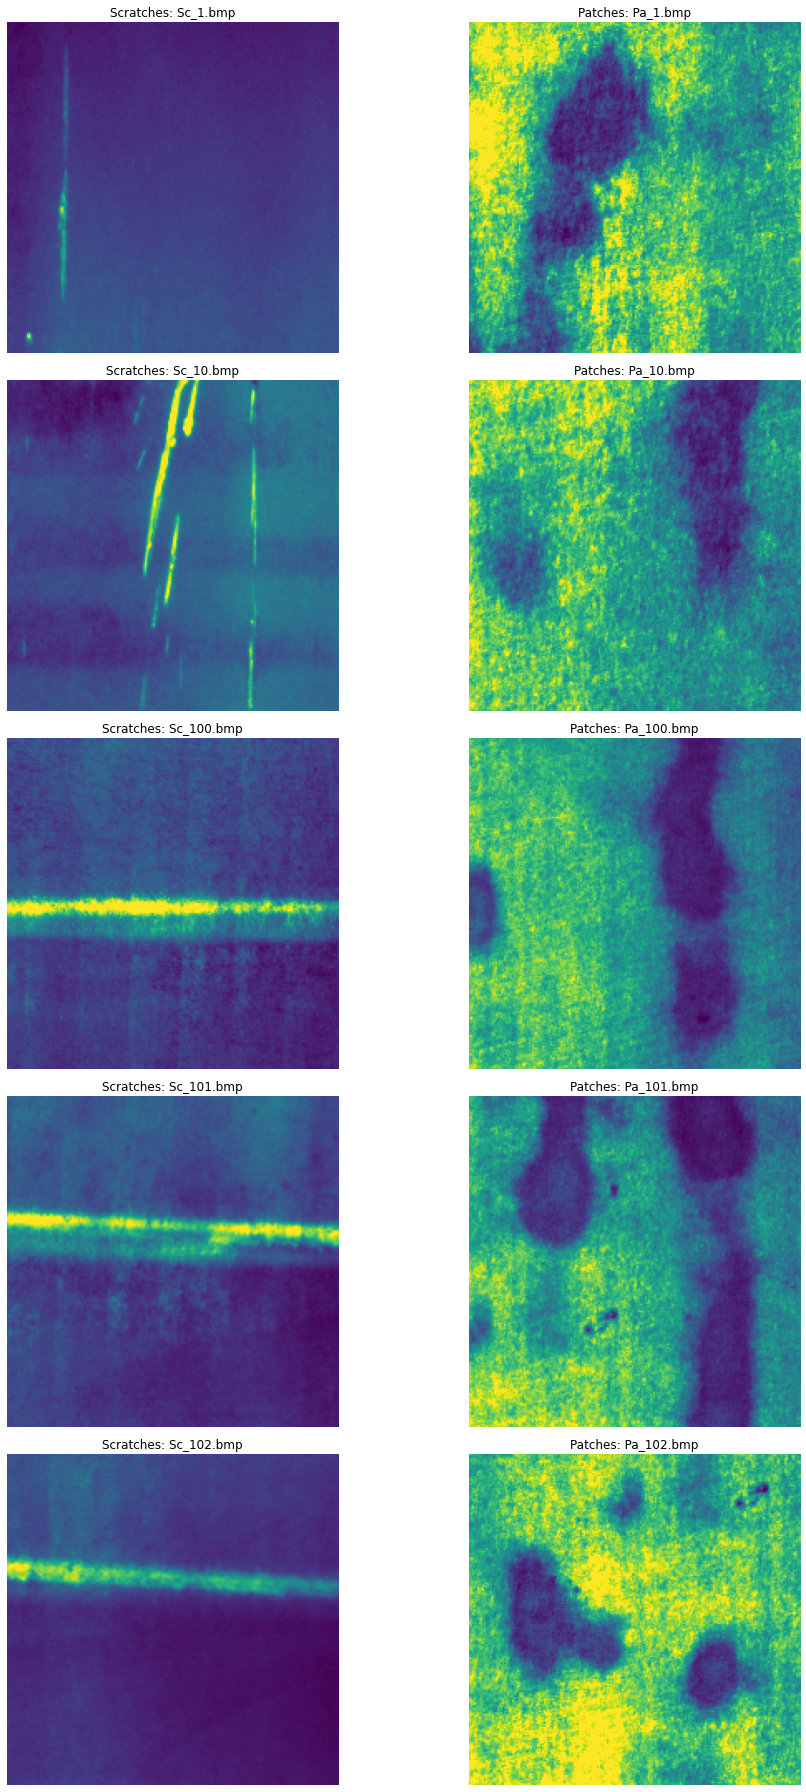

In [5]:

# Confused classes
confused_classes = [
    ("Pitted", "Inclusion"),
    ("Scratches", "Patches")
]

# Function to load a few images from each class
def load_images_for_visualization(directory, class1, class2, num_images=5):
    class1_dir = os.path.join(directory, class1)
    class2_dir = os.path.join(directory, class2)
    
    class1_images = [os.path.join(class1_dir, img) for img in os.listdir(class1_dir)[:num_images]]
    class2_images = [os.path.join(class2_dir, img) for img in os.listdir(class2_dir)[:num_images]]
    
    return class1_images, class2_images

# Visualize images side-by-side
def visualize_images(images1, images2, label1, label2):
    plt.figure(figsize=(12, 8))
    num_images = min(len(images1), len(images2))
    plt.figure(figsize=(15, num_images * 5))
    
    for i in range(num_images):
        # Load images
        img1 = Image.open(images1[i])
        img2 = Image.open(images2[i])
        
        # Plot side by side
        plt.subplot(num_images, 2, i * 2 + 1)
        plt.imshow(img1)
        plt.axis('off')
        plt.title(f"{label1}: {os.path.basename(images1[i])}")
        
        plt.subplot(num_images, 2, i * 2 + 2)
        plt.imshow(img2)
        plt.axis('off')
        plt.title(f"{label2}: {os.path.basename(images2[i])}")
    
    plt.tight_layout()
    plt.show()

# Visualize confused classes
for class1, class2 in confused_classes:
    print(f"Visualizing {class1} vs {class2}...")
    images1, images2 = load_images_for_visualization(test_dir, class1, class2, num_images=5)
    visualize_images(images1, images2, class1, class2)


<b>Conclusion :</b>

* We trained three models SVM, Random Forest and CNN for our image classification problem.
* The accuracy for test dataset of our models are as following
 * SVM - 80.5
 * Random Forest - 64.0
 * CNN - 95.8
* In our case the SVM model outperforms Random Forest the possible reasons could be 
 * SVM is particularly effective in handling high-dimensional datasets, where the number of features is much greater than the number of samples, whereas  Random Forest may struggle with high-dimensional data because it tries to split on features, and many splits may be noisy or irrelevant in high-dimensional spaces.
 * SVM, especially with the RBF kernel, excels at creating a decision boundary that maximizes the margin between classes, whether the data is linearly or nonlinearly separable, whereas Random Forest uses axis-aligned splits, which may not work well if the decision boundary is complex or curved.
* Our models are generally confused between two sets of images Scratches with Patches and Pitted with inclusion this could be because of high similarity between these two set of images. Simple models are not able to capture the difference but CNN model is able to capture the difference.
* The best performing model in CNN which is able to classify most of the images correctly. The obvious reason is the Concnets which are able to capture features better that machine learning models.